## 1. Importing Libraries

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.tokenize import WhitespaceTokenizer 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier

## 2. Loading Dataset

In [4]:
df=pd.read_csv('news.csv', index_col='Unnamed: 0')

In [5]:
df.head()

,title,text,label
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


The first column identifies the news, the second and third are the title and text, and the fourth column has labels denoting whether the news is REAL or FAKE

In [6]:
df.shape

(6335, 3)

In [7]:
df.isnull().sum()

title    0
text     0
label    0
dtype: int64

We create a new column called "length" which contains the number of words in the text column.

In [8]:
df['length']=df['text'].apply(lambda x :len(x))

In [9]:
df.head()

,title,text,label,length
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,7518
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,2646
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,2543
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,2660
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1840


## 3. Exploratory Data Analysis

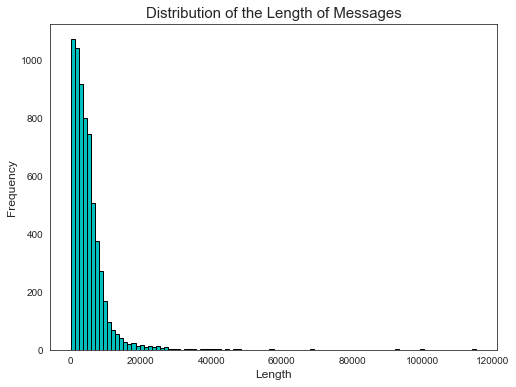

In [24]:
plt.figure(figsize=(8,6))
sns.set_style('white')
plt.hist(x='length', data=df,bins=100,edgecolor='black',color='c')
plt.title('Distribution of the Length of Messages',fontsize=15)
plt.xlabel('Length',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.show()

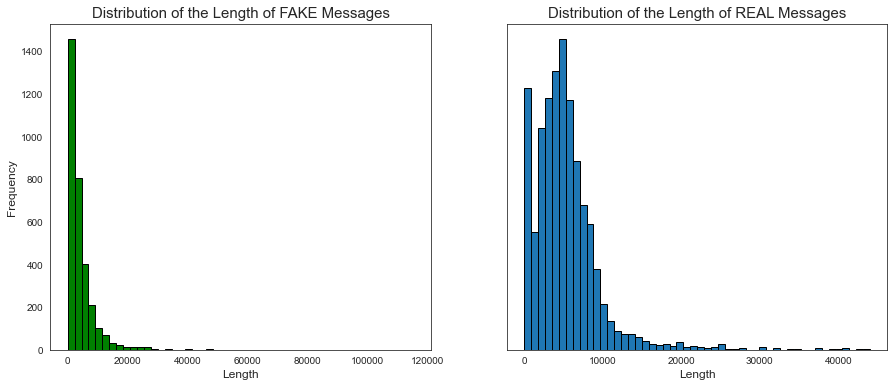

In [26]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.hist(x='length', data=df[df['label']=='FAKE'],bins=50,edgecolor='black', color='g')
plt.title('Distribution of the Length of FAKE Messages',fontsize=15)
plt.ylabel('Frequency',fontsize=12)
plt.xlabel('Length',fontsize=12)

plt.subplot(1,2,2)
plt.hist(x='length', data=df[df['label']=='REAL'],bins=50,edgecolor='black')
plt.title('Distribution of the Length of REAL Messages',fontsize=15)
plt.xlabel('Length',fontsize=12)
plt.yticks([])
plt.show()

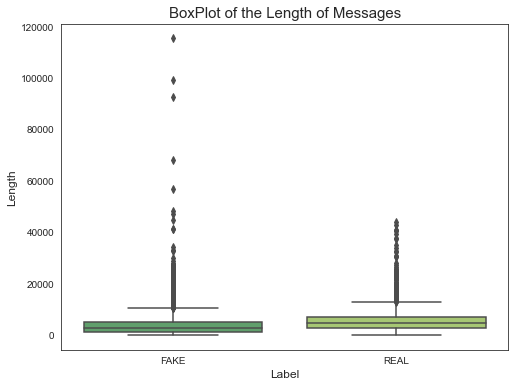

In [28]:
plt.figure(figsize=(8,6))
sns.boxplot(x='label', y='length', data=df, palette='summer')
plt.title('BoxPlot of the Length of Messages',fontsize=15)
plt.xlabel('Label',fontsize=12)
plt.ylabel('Length',fontsize=12)
plt.show()

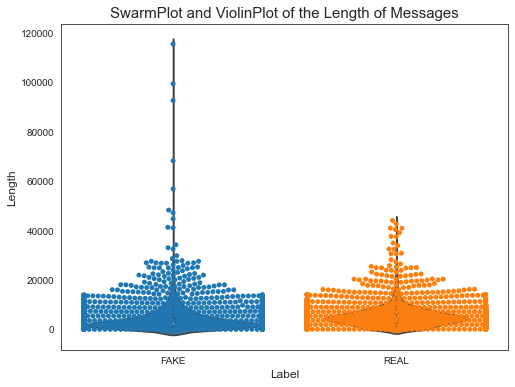

In [102]:
plt.figure(figsize=(8,6))
sns.violinplot(x='label', y='length', data=df)
sns.swarmplot(x='label', y='length', data=df)
plt.title('SwarmPlot and ViolinPlot of the Length of Messages',fontsize=15)
plt.xlabel('Label',fontsize=12)
plt.ylabel('Length',fontsize=12)
plt.show()

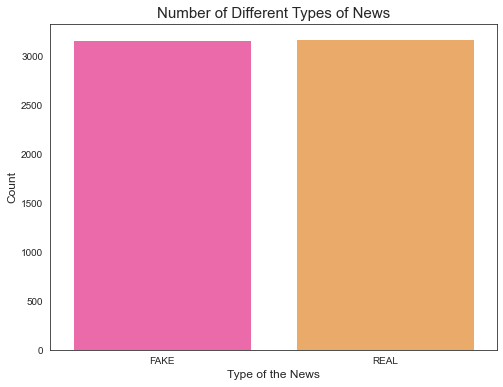

In [103]:
plt.figure(figsize=(8,6))
sns.countplot(x='label', data=df, palette='spring')
plt.title('Number of Different Types of News',fontsize=15)
plt.xlabel('Type of the News',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.show()

## 4. Fake/Real News Prediction

### 4.1. Text Preprocessing Function

We define a preprocessing function that performs the following operations:

- Converting text to lower case

- Removing numbers from the text corpus

- Removing punctuation from the text corpus

- Removing special characters such as ‘<’, ‘…’ from the text corpus

- Removing english stopwords

- Stemming words to root words

- Removing extra whitespaces from the text corpus

In [36]:
ps=PorterStemmer()
wst= WhitespaceTokenizer() 

##### 1. Converting text to lower case
def lower_func (x):
    return x.lower()


##### 2. Removing Numbers from the text corpus
def remove_number_func (x): 
    new=""
    for a in x:
        if a.isdigit()==False:
            new=new+a
    return new


##### 3. Removing punctuation 
def remove_punc_func(x):
    new=''
    for a in x:
        if a not in string.punctuation:
            new=new+a
    return new

##### 4. Removing special characters
def remove_spec_char_func(x):
    new=''
    for a in x:
        if (a.isalnum()==True) or (a==' '):
            new=new+a
    return(new)

##### 5. Removing english stopwords
def remove_stopwords(x):
    new=[]
    for a in x.split():
        if a not in stopwords.words('english'):
            new.append(a)
    return " ".join(new)

##### 6. Stemming words to root words
def stem_func(x):
    wordlist = word_tokenize(x)
    psstem = [ps.stem(a) for a in wordlist]
    return ' '.join(psstem)

##### 7. Removing extra whitespaces 
def remove_whitespace_func(x):
    return(wst.tokenize(x))

def compose(f, g):
    return lambda x: f(g(x))

final=compose(compose(compose(compose(compose(compose(remove_whitespace_func,stem_func),remove_stopwords),remove_spec_char_func),remove_punc_func),remove_number_func),lower_func)

### 4.2. Splitting the Dataset 

In [37]:
X=df['text']
y=df['label']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

### 4.3. Creating Data Pipeline

#### 4.3.1. MultinomialNB Classifier without Text Preprocessing 

In [39]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', MultinomialNB()), 
])

In [40]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [41]:
prediction1=pipeline.predict(X_test)

In [42]:
print(confusion_matrix(y_test,prediction1))
print('\n')
print(classification_report(y_test,prediction1))

[[409 229]
 [  4 625]]


              precision    recall  f1-score   support

        FAKE       0.99      0.64      0.78       638
        REAL       0.73      0.99      0.84       629

    accuracy                           0.82      1267
   macro avg       0.86      0.82      0.81      1267
weighted avg       0.86      0.82      0.81      1267



#### 4.3.2. MultinomialNB Classifier with Text Preprocessing

In [43]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=final)),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', MultinomialNB()), 
])

In [44]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x000001C875ED9C18>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose

In [45]:
prediction2=pipeline.predict(X_test)

In [46]:
print(confusion_matrix(y_test,prediction2))
print('\n')
print(classification_report(y_test,prediction2))

[[466 172]
 [ 14 615]]


              precision    recall  f1-score   support

        FAKE       0.97      0.73      0.83       638
        REAL       0.78      0.98      0.87       629

    accuracy                           0.85      1267
   macro avg       0.88      0.85      0.85      1267
weighted avg       0.88      0.85      0.85      1267



#### 4.3.3. MultinomialNB Classifier with Only Removing Stop Words

In [61]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer='word', stop_words='english')),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', MultinomialNB()), 
])

In [62]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [63]:
prediction3=pipeline.predict(X_test)

In [64]:
print(confusion_matrix(y_test,prediction3))
print('\n')
print(classification_report(y_test,prediction3))

[[450 188]
 [ 14 615]]


              precision    recall  f1-score   support

        FAKE       0.97      0.71      0.82       638
        REAL       0.77      0.98      0.86       629

    accuracy                           0.84      1267
   macro avg       0.87      0.84      0.84      1267
weighted avg       0.87      0.84      0.84      1267



#### 4.3.4. Passive Aggressive Classifier without Text Preprocessing

In [65]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', PassiveAggressiveClassifier()), 
])

In [66]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                          

In [67]:
prediction4=pipeline.predict(X_test)

In [68]:
print(confusion_matrix(y_test,prediction4))
print('\n')
print(classification_report(y_test,prediction4))

[[583  55]
 [ 39 590]]


              precision    recall  f1-score   support

        FAKE       0.94      0.91      0.93       638
        REAL       0.91      0.94      0.93       629

    accuracy                           0.93      1267
   macro avg       0.93      0.93      0.93      1267
weighted avg       0.93      0.93      0.93      1267



#### 4.3.5. Passive Aggressive Classifier with Text Preprocessing

In [80]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=final)),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', PassiveAggressiveClassifier()), 
])

In [81]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x000001C875ED9C18>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                             early_stopping=False,
       

In [82]:
prediction5=pipeline.predict(X_test)

In [83]:
print(confusion_matrix(y_test,prediction5))
print('\n')
print(classification_report(y_test,prediction5))

[[591  47]
 [ 43 586]]


              precision    recall  f1-score   support

        FAKE       0.93      0.93      0.93       638
        REAL       0.93      0.93      0.93       629

    accuracy                           0.93      1267
   macro avg       0.93      0.93      0.93      1267
weighted avg       0.93      0.93      0.93      1267



#### 4.3.6. Passive Aggressive Classifier with Only Removing Stop Words

In [84]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer='word', stop_words='english')),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', PassiveAggressiveClassifier()), 
])

In [85]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                          

In [86]:
prediction6=pipeline.predict(X_test)

In [87]:
print(confusion_matrix(y_test,prediction6))
print('\n')
print(classification_report(y_test,prediction6))

[[588  50]
 [ 43 586]]


              precision    recall  f1-score   support

        FAKE       0.93      0.92      0.93       638
        REAL       0.92      0.93      0.93       629

    accuracy                           0.93      1267
   macro avg       0.93      0.93      0.93      1267
weighted avg       0.93      0.93      0.93      1267



#### 4.3.7. Random Forest Classifier without Text Preprocessing

In [88]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', RandomForestClassifier()), 
])

In [89]:
pipeline.fit(X_train, y_train)

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

In [90]:
prediction7=pipeline.predict(X_test)

In [91]:
print(confusion_matrix(y_test,prediction7))
print('\n')
print(classification_report(y_test,prediction7))

[[558  80]
 [133 496]]


              precision    recall  f1-score   support

        FAKE       0.81      0.87      0.84       638
        REAL       0.86      0.79      0.82       629

    accuracy                           0.83      1267
   macro avg       0.83      0.83      0.83      1267
weighted avg       0.83      0.83      0.83      1267



#### 4.3.8. Random Forest  Classifier with Text Preprocessing

In [92]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=final)),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', RandomForestClassifier()), 
])

In [93]:
pipeline.fit(X_train, y_train)

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x000001C875ED9C18>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                              

In [94]:
prediction8=pipeline.predict(X_test)

In [95]:
print(confusion_matrix(y_test,prediction8))
print('\n')
print(classification_report(y_test,prediction8))

[[545  93]
 [162 467]]


              precision    recall  f1-score   support

        FAKE       0.77      0.85      0.81       638
        REAL       0.83      0.74      0.79       629

    accuracy                           0.80      1267
   macro avg       0.80      0.80      0.80      1267
weighted avg       0.80      0.80      0.80      1267



#### 4.3.9. Random Forest  Classifier with Only Removing Stop Words

In [96]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer='word', stop_words='english')),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', RandomForestClassifier()), 
])

In [97]:
pipeline.fit(X_train, y_train)

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

In [98]:
prediction9=pipeline.predict(X_test)

In [99]:
print(confusion_matrix(y_test,prediction9))
print('\n')
print(classification_report(y_test,prediction9))

[[559  79]
 [129 500]]


              precision    recall  f1-score   support

        FAKE       0.81      0.88      0.84       638
        REAL       0.86      0.79      0.83       629

    accuracy                           0.84      1267
   macro avg       0.84      0.84      0.84      1267
weighted avg       0.84      0.84      0.84      1267



In [100]:
print('MultinomialNB Classifier without text pre-processing', accuracy_score(y_test,prediction1))
print('MultinomialNB Classifier with text pre-processing: ', accuracy_score(y_test,prediction2))
print('MultinomialNB Classifier with only removing stop words', accuracy_score(y_test,prediction3))
print('\n')
print('Passive Aggressive Classifier without text pre-processing: ', accuracy_score(y_test,prediction4))
print('Passive Aggressive Classifier with text pre-processing: ', accuracy_score(y_test,prediction5))
print('Passive Aggressive Classifier with only removing stop words: ', accuracy_score(y_test,prediction6))
print('\n')
print('Random Forest Classifier without text pre-processing: ', accuracy_score(y_test,prediction7))
print('Random Forest Classifier with text pre-processing: ', accuracy_score(y_test,prediction8))
print('Random Forest Classifier with only removing stop words: ', accuracy_score(y_test,prediction9))

MultinomialNB Classifier without text pre-processing 0.8161010260457774
MultinomialNB Classifier with text pre-processing:  0.840568271507498
MultinomialNB Classifier with only removing stop words 0.840568271507498


Passive Aggressive Classifier without text pre-processing:  0.925808997632202
Passive Aggressive Classifier with text pre-processing:  0.9289660615627466
Passive Aggressive Classifier with only removing stop words:  0.9265982636148382


Random Forest Classifier without text pre-processing:  0.8318863456985004
Random Forest Classifier with text pre-processing:  0.7987371744277821
Random Forest Classifier with only removing stop words:  0.8358326756116812


We can see that the Passive Agreesive Classifier is more effective in predicting whether news is fake or real as compared with MultinomialNB and Random Forest Classifiers. The highest accuracy score was obtained for the Passive Agreesive Classifier with  text pre-processing. 

## 5. Conclusion

In this project, the following tasks were preformed:

- We performed exploratory data analysis on the real and fake news dataset. 

- We built binary classifiers that classify fake news and real news on the basis of words in the text of the news articles. We used three different classifiers including Random Forest Classifier, Naive-Bayes Classifier and passive Agressive Classifier to classify articles into real/fake news categories and applied them with and without text preprocessing and with only removing the stop words.

- Passive Aggressive was the best model for this analysis of the text of the news. The highest accuracy was 92.89% and it was obtained for the Passive Aggressive model applied on the news which have been revised by our text preprocessing function.